In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import geopandas as gpd
import seaborn as sns
from matplotlib.patches import Polygon

In [2]:
def get_shelf_mask(area_num):

    mask = shelf_mask_da.where((shelf_mask_da==area_num))      
        
    mask2 = mask.dropna(dim = 'lon', how='all')
    mask2 = mask2.dropna(dim = 'lat', how='all')
    mask_lat = mask2.lat.values
    mask_lon = mask2.lon.values
    
    return mask, mask_lat, mask_lon

def clip_data_to_mask(ds, area_num):
    mask, mask_lat, mask_lon= get_shelf_mask(area_num)
    
    mask_np = mask.sel(lat = slice(np.max(mask_lat), np.min(mask_lat)), lon = slice(np.min(mask_lon), np.max(mask_lon))).values
    low_el_mask = el_mask_da.sel(lat = slice(np.max(mask_lat), np.min(mask_lat)), lon = slice(np.min(mask_lon), np.max(mask_lon))).values
    area = area_da.sel(lat = slice(np.max(mask_lat), np.min(mask_lat)), lon = slice(np.min(mask_lon), np.max(mask_lon)))
    clipped_ds = ds.sel(lat = slice(np.max(mask_lat), np.min(mask_lat)), lon = slice(np.min(mask_lon), np.max(mask_lon)))
    
    mask_np[~np.isnan(mask_np)]=1
    shelf_area = (mask_np*area*low_el_mask).sum(dim = ['lat','lon'])

    ts = (clipped_ds*mask*area*low_el_mask).sum(dim = ['lat','lon'])/shelf_area
    return ts

In [5]:
gamma10 = pd.read_csv('csvs/fac_deg0C.csv')
gamma4 = pd.read_csv('csvs/fac_icelens_gamma4.csv')
linear = pd.read_csv('csvs/fac_icelens_linear.csv')
merra = pd.read_csv('csvs/fac_merra.csv')

ssp1_data = xr.open_dataset(f'netcdf_results/emulator_FAC/ssp1_fac_TP1.nc')
ssp3_data = xr.open_dataset(f'netcdf_results/emulator_FAC/ssp3_fac_TP1.nc')
ssp5_data = xr.open_dataset(f'netcdf_results/emulator_FAC/ssp5_fac_TP1.nc')

last_ssp5 = ssp5_data.isel(year = -1).fac
last_ssp3 = ssp3_data.isel(year = -1).fac
last_ssp1 = ssp1_data.isel(year = -1).fac

hist_data = xr.open_dataset(f'netcdf_results/emulator_FAC/era_TP1.nc')
shelf_mask_da = xr.open_dataarray('masks/era/shelf_mask.nc')
el_mask_da = xr.open_dataarray('masks/era/low_elevation.nc')
area_da = xr.open_dataarray('masks/era/area.nc')

shelves = gpd.read_file("masks/ice_shelves.geojson")
shelves.at[69, 'NAME']='Ross west'
shelves.at[70, 'NAME']='Ross east'

In [6]:
shelf_names = ['Bach', 'George_VI', 'LarsenB', 'LarsenC', 'LarsenD',
              'Stange', 'Wilkins', 'Ronne', 'Filchner','Atka','Baudouin',
              'Borchgrevink','Brunt_Stancomb','Ekstrom','Fimbul','Jelbart','Lazarev',
               'Nivl','Prince_Harald','Quar','Riiser-Larsen','Amery', 'Shackleton',
               'Tracy_Tremenchus','West','Cook','Drygalski','Holmes','Mariner','Mertz','Moscow_University',
              'Totten','ross2','Nickerson','Sulzberger','Abbot','Cosgrove','Crosson',
              'Dotson','Getz','Pine_Island','Thwaites','Venable']

shelf_numbers = [45, 44, 50, 7, 5,
              51, 49, 33, 34,123,117,
              118,35,38,120,124,119,
               121,157,37,36,114, 99,
               23,101,89,72,155,82,90,156,
              97,69,63,64,109,53,56,
              57,59,54,55,52]

plot_names = ['Bach', 'George VI', 'Larsen B', 'Larsen C', 'Larsen D',
              'Stange', 'Wilkins', 'Ronne', 'Filchner','Atka','Baudouin',
              'Borchgrevink','Brunt-Stancomb','Ekstrom','Fimbul','Jelbart','Lazarev',
               'Nivlisen','Prince Harald','Quar','Riiser-Larsen','Amery', 'Shackleton',
               'Tracy Tremenchus','West','Cook','Drygalski','Holmes','Mariner','Mertz','Moscow University',
              'Totten','Ross','Nickerson','Sulzberger','Abbot','Cosgrove','Crosson',
              'Dotson','Getz','Pine Island','Thwaites','Venable']

merra_shelves = merra.name.values

/glade/work/devond/conda-envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator


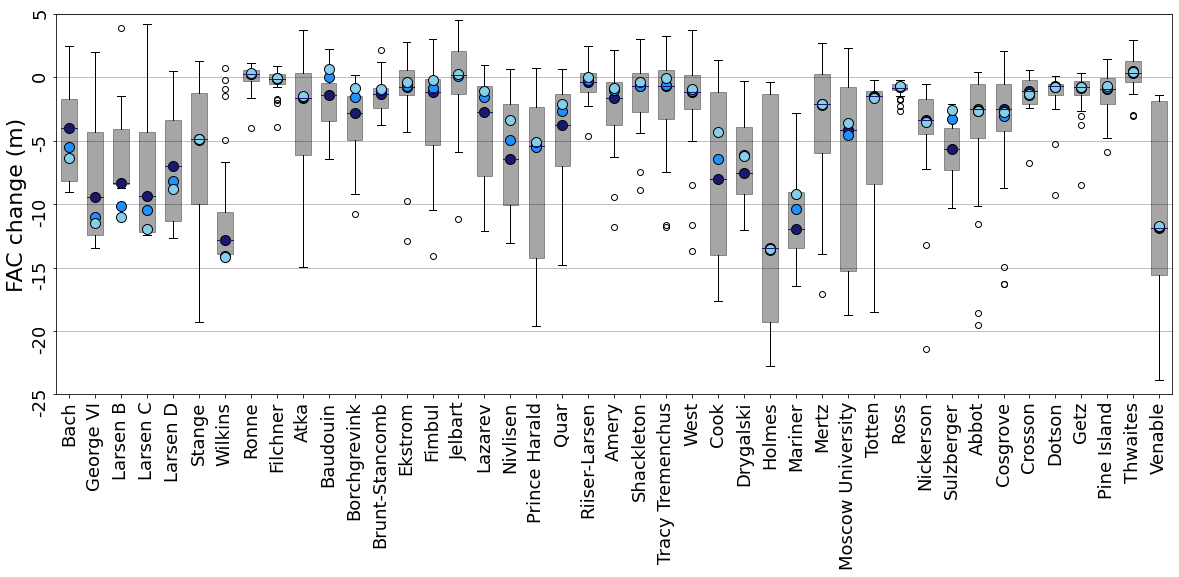

In [7]:
fig, ax = plt.subplots(1,1,figsize = (20,7))

for i in range(len(shelf_names)):
    n = shelf_names[i]
    num = shelf_numbers[i]
    
    ts = clip_data_to_mask(last_ssp5, num)
    change = ts - gamma10.loc[gamma10.name == n]['hist'].values[0]
    g10 = float((gamma10.ssp5 - gamma10['hist']).loc[gamma10.name==n].values)
    g4 = float((gamma4.ssp5 - gamma4['hist']).loc[gamma4.name==n].values)
    lin = float((linear.ssp5 - linear['hist']).loc[linear.name==n].values)
    if n in merra_shelves:
        m = float((merra.ssp5 - merra['hist']).loc[merra.name==n].values)
    else:m=np.nan
    
    ax.boxplot([change], positions=[i], notch=False, sym='o', vert=True, whis=1.5, widths = 0.6, patch_artist=True, 
               boxprops=dict(facecolor='black', alpha = 0.35),
                medianprops=dict(color='midnightblue'))
    #ax.add_patch(Polygon(box_coords, facecolor='blue'))
    ax.plot(i,g10, '.', color = 'midnightblue', markersize = 20, markeredgecolor = 'k')
    ax.plot(i,g4, '.', color = 'dodgerblue', markersize = 20, markeredgecolor = 'k')
    ax.plot(i,lin, '.', color = 'skyblue', markersize = 20, markeredgecolor = 'k')
    #ax.plot(i,m, '.', color = 'maroon', markersize = 20, markeredgecolor = 'k')
    
ax.set_xticklabels(plot_names, rotation = 90, fontsize = 18);
ax.set_ylim([-25,5]);
ax.set_yticklabels([-25,-20,-15,-10,-5,0,5], fontsize = 18, rotation = 90);
ax.set_ylabel('FAC change (m)', fontsize = 22)
ax.grid(axis='y')
#plt.savefig('figures/ssp5_model_comp.png', dpi=300, transparent = True, bbox_inches = 'tight')